# Algorand Covid-19 Project
# Rahul Zalkikar | rz1567@nyu.edu

## Source documentation:
https://github.com/algorandfoundation/IReport-Covid/blob/master/js/retrieveData.js

In [912]:
import algosdk
import math
import pandas as pd
import numpy as np

In [879]:
def connect_testnet():
    algod_address_testnet = "https://testnet-algorand.api.purestake.io/ps1"
    port_test = ""
    token_test = {
       "X-API-Key": "B3SU4KcVKi94Jap2VXkK83xx38bsv95K5UZm2lab",
    }

    algod_client_test = algosdk.algod.AlgodClient(port_test, algod_address_testnet, token_test)
    return algod_client_test

In [880]:
def connect_mainnet():
    algod_address_mainnet = "https://mainnet-algorand.api.purestake.io/ps1"
    port = ""
    purestake_api_key = 'XXXXXXXXXXX'
    token = {
        'X-API-key' : purestake_api_key,
    }

    algod_client = algosdk.algod.AlgodClient(port, algod_address_mainnet, token) # Initialize the algod client and get the basic parameters
    return algod_client

# if using my own node...
#token = "token from the file algod.token"
#server = "http://127.0.0.1" #localhost
#port = 8081 # default

In [881]:
def client_check(algod_client):
    try:
        status = algod_client.status()
    except Exception as e:
        print("Failed to get algod status: {}".format(e))

    if status:
        print("algod last round: {}".format(status.get("lastRound")))
        print("algod time since last round: {}".format(status.get("timeSinceLastRound")))
        print("algod catchup: {}".format(status.get("catchupTime")))
        print("algod latest version: {}".format(status.get("lastConsensusVersion")))

    # Retrieve latest block information                                                                                                                                               
    last_round = algod_client.status().get("lastRound")
    print("####################")
    block = algod_client.block_info(last_round)
    print(block)

In [882]:
#algod_client_test = connect_testnet()
#client_check(algod_client_test)

In [883]:
algod_client = connect_mainnet()
client_check(algod_client)

algod last round: 5785664
algod time since last round: 2885469453
algod catchup: 0
algod latest version: https://github.com/algorandfoundation/specs/tree/4a9db6a25595c6fd097cf9cc137cc83027787eaa
####################
{'hash': 'T4ZJKZFN7OPRAFQUC3TIL4CDHCXUR3LGDP53AJ2NC5WHHLTWV35A', 'previousBlockHash': 'O7Q3RXUKJW6XOQMHOSOJJ3HHFPGRB24SN2C4BFIH3PF26BMFAGDA', 'seed': 'ZLN6Y5YO6A57PUWQDZI4TY6KOPYLES6G4EWIBETQWT3ACN53DURA', 'proposer': 'OXWIMTRZA5TVPABJF534EBBERJG367OLAB6VFN4RAW5P6CQEMXEX7VVDV4', 'round': 5785664, 'period': 0, 'txnRoot': 'WRS2VL2OQ5LPWBYLNBCZV3MEQ4DACSRDES6IUKHGOWYQERJRWC5A', 'reward': 114116, 'rate': 25999980, 'frac': 2650625200, 'txns': {}, 'timestamp': 1585670298, 'currentProtocol': 'https://github.com/algorandfoundation/specs/tree/4a9db6a25595c6fd097cf9cc137cc83027787eaa', 'nextProtocol': '', 'nextProtocolApprovals': 0, 'nextProtocolVoteBefore': 0, 'nextProtocolSwitchOn': 0, 'upgradePropose': '', 'upgradeApprove': False}


In [889]:
# For retrieving the real covid data from mainnet

address = "COVIDR5MYE757XMDCFOCS5BXFF4SKD5RTOF4RTA67F47YTJSBR5U7TKBNU"
fromRound = 5646000
maxTxnPerCall = 500 # max transactions in a batch
batchSize = 512 #Read the transactions from the blockchain in 512-block installations

params = algod_client.suggested_params()
print("total rounds:",params['lastRound'] - fromRound)
#lastRound_testing = fromRound + 20*batchSize
#print("testing rounds:",lastRound_testing - fromRound)

total rounds: 139673


In [885]:
#  A recursive function for getting a batch of transactions, to overcome
# the limitation of maxTxnPerCall transaction per call to the API

def getTransactionBatch(fromRnd, toRnd):
    
    if (fromRnd > toRnd):# sanity check
        return []
    
    txs = algod_client.transactions_by_address(address,fromRnd,toRnd,maxTxnPerCall) 
    # make an API call to get the transactions - 500 at a time
    
    return txs['transactions']
    
    '''
    # If we got all the transactions, just return them
    if (fromRnd == toRnd | len(txs['transactions']) < maxTxnPerCall):
        return txs['transactions']
    
        # FIXME: If a single block contains more than maxTxnPerCall
        # transactions for the target address, the code above will return
        # only maxTxnPerCall of them.
        # This is an unlikely case, and not easy to handle. The only way to
        # handle it is to call algod.block(round#), then go over all the
        # transactions in this block and take only the ones corresponding
        # to the target address.
    
    else: # recursive call to get them in two smaller chunks
        midRnd = math.floor((fromRnd+toRnd) / 2)
        txns1 = getTransactionBatch(fromRnd, midRnd)
        txns2 = getTransactionBatch(midRnd+1, toRnd)
        # return the concatenation of the two chunks
        return txns1.concat(txns2)
    '''

In [1100]:
txns = []
batch_limit = 100
for i in range(0,batch_limit):
    txns.extend(getTransactionBatch(fromRound, params['lastRound'])) # Fetch transactions for these rounds 
print("found {} transactions".format(len(txns)))

found 50000 transactions


In [1101]:
def decode_node_data(transactions):
    
    trans_df = pd.DataFrame()
    
    for i in range(len(transactions)):
        
        tx_dict = transactions[i]
        encoded_note = tx_dict['noteb64']
        
        ###################### FIX - VERY INEFFICENT, BUT WORKS FOR NOW
        decoded_note = algosdk.encoding.msgpack.unpackb(algosdk.encoding.base64.b64decode(encoded_note))
        
        cleaned_note_dict = {h:None for h in headers}
        
        for key,value in decoded_note.items():
            key = key.decode("utf-8")
            if str(key) == "d":
                for k,v in value.items():
                    new_value = ""
                    new_key = ""
                    
                    if "b" in str(v): new_value = str(v)[1:]
                    else: new_value = str(v)
                    if "b" in str(k): new_key = k.decode('utf-8')
                    else: new_key = str(k)
                        
                    if "'" in new_value:
                        new_value = new_value.replace("'", "")
                    cleaned_note_dict[new_key] = str(new_value)
        
        trans_df = trans_df.append(cleaned_note_dict, ignore_index=True)
        
    return trans_df

In [1102]:
# attribute array
headers = [
    '_t',  
    '_v',  

    # general demographic data
    'gc',  # string, country code (see Location Data section below)
    'gr',  # string, region code  (see Location Data section below)
    'gzp', # string, 3-digit zip code (US only)
    'ga',  # integer, age group, if present must be in 1,11,21,31,41,51,56,61,66,71,76,81,85
    'gs',  # string , gender, if present must be 'm','f'

    # symptoms
    'sz',  # integer, is symptomatic, no-answer=0/no=-1/yes=1
    's1',  # boolean, fever
    's2',  # boolean, cough
    's3',  # boolean, difficulty breathing
    's4',  # boolean, fatigue
    's5',  # boolean, sore throat
    'sds', # date, when symptoms started, yyyy-mm-dd
    'sde', # date, when symptoms ended, yyyy-mm-dd
    'sdn', # boolean, still symptomatic

    #tested
    'tz',  # integer, tested, no-answer=0/no=-1/yes=1
    'tt',  # integer, tried to get tested, no=-1, yes=1, yes but was denied=2
    'td',  # date, test date, yyyy-mm-dd
    'tr',  # integer, test results, -1=negative,1=positive,2=waiting for result
    'tl',  #  integer, test location, 1=Dr office/2=Hospital/3=Urgent care/4=Ad-hoc center/5=Other

    # medical care
    'mz',  #  integer, received care, no-answer=0/no=-1/yes=1
    'm1',  #  boolean, doctor's office
    'm2',  #  boolean, walk-in clinic
    'm3',  #  boolean, virtual care
    'm4',  #  boolean, hospital/ER
    'm5',  #  boolean, other
    'mh',  #  integer, hospitalized, no-answer=0/no=-1/yes=1
    'mhs', #  date, when admitted, yyyy-mm-dd
    'mhe', #  date, when discharged, yyyy-mm-dd
    'mhn', #  boolean, still in hospital

    # quarantine
    'qz',  # integer, was quarantined, no-answer=0/no=-1/yes=1
    'q1',  # boolean, due to symptoms
    'q2',  # boolean, voluntarily
    'q3',  # boolean, personally required
    'q4',  # boolean, general quarantine
    'qds', # date, when quarantine started, yyyy-mm-dd
    'qde', # date, when quarantine ended, yyyy-mm-dd
    'qdn', # boolean, still quarantined
    'ql',  # integer, left quarantine temporarily no-answer=0/no=-1/yes=1

    'consent' # boolean' , user's consent, mandatory, must be 'true'
]

cols = ["_t","_v","consent","age_group","country_code","region_code","gender","3_dig_zip",
          "doctors_office","walk_in_clinic","virtual_care","hospital_or_ER","other",
           "hospitalized","when_discharged","still_in_hospital","when_admitted","received_care",
          "symptom_quarantine","voluntary_quarantine","personally_required_quarantine","general_quarantine",
          "when_quarantine_ended","still_in_quarantine","when_quarantine_started","left_quarantine_temporarily","was_quarantined",
          "fever","cough","difficulty_breathing","fatigue","sore_throat","when_symptoms_ended","still_symptomatic","when_symptoms_started","is_symptomatic",
          "test_date","test_location","test_results","tried_to_get_tested","tested"]

print(len(cols)==len(headers))

True


In [1103]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_df = decode_node_data(txns)
data_df.columns = cols
display(data_df.head(50))

,_t,_v,consent,age_group,country_code,region_code,gender,3_dig_zip,doctors_office,walk_in_clinic,virtual_care,hospital_or_ER,other,hospitalized,when_discharged,still_in_hospital,when_admitted,received_care,symptom_quarantine,voluntary_quarantine,personally_required_quarantine,general_quarantine,when_quarantine_ended,still_in_quarantine,when_quarantine_started,left_quarantine_temporarily,was_quarantined,fever,cough,difficulty_breathing,fatigue,sore_throat,when_symptoms_ended,still_symptomatic,when_symptoms_started,is_symptomatic,test_date,test_location,test_results,tried_to_get_tested,tested
0,report,1,True,30,US,PA,m,190,None,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
1,report,1,True,40,DE,None,f,None,None,None,None,None,None,None,None,None,None,-1,None,None,None,True,None,True,2020-03-21,1,1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
2,report,1,True,20,IT,72,f,None,None,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
3,report,1,True,55,IT,72,m,None,None,None,None,None,None,None,None,None,None,-1,None,None,None,True,None,True,2020-03-16,-1,1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
4,report,1,True,20,GB,LAN,m,None,None,None,None,None,None,None,None,None,None,-1,True,None,None,None,2020-03-24,None,2020-03-15,-1,1,None,True,True,True,True,2020-03-24,None,2020-03-13,1,None,None,None,-1,-1
5,report,1,True,50,IT,None,f,None,None,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
6,report,1,True,50,IT,None,f,None,None,None,None,None,None,None,None,None,None,-1,None,None,True,None,None,True,2020-03-10,-1,1,None,None,None,None,None,None,None,None,-1,None,None,None,None,-1
7,report,1,True,20,IT,72,m,None,None,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
8,report,1,True,20,IT,72,f,None,None,None,None,None,None,None,None,None,None,-1,None,True,None,True,None,True,2020-03-04,-1,1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1
9,report,1,True,40,IT,72,m,None,None,None,None,None,None,None,None,None,None,-1,None,True,None,True,None,True,2020-03-07,1,1,None,None,None,None,None,None,None,None,-1,None,None,None,-1,-1


In [1104]:
data_df.to_csv('covidData.csv',index=False)

### BASIC DATA PROCESSING

In [1105]:
data_df = pd.read_csv('covidData.csv')
data_df.head()

,_t,_v,consent,age_group,country_code,region_code,gender,3_dig_zip,doctors_office,walk_in_clinic,virtual_care,hospital_or_ER,other,hospitalized,when_discharged,still_in_hospital,when_admitted,received_care,symptom_quarantine,voluntary_quarantine,personally_required_quarantine,general_quarantine,when_quarantine_ended,still_in_quarantine,when_quarantine_started,left_quarantine_temporarily,was_quarantined,fever,cough,difficulty_breathing,fatigue,sore_throat,when_symptoms_ended,still_symptomatic,when_symptoms_started,is_symptomatic,test_date,test_location,test_results,tried_to_get_tested,tested
0,report,1,True,30.0,US,PA,m,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
1,report,1,True,40.0,DE,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,True,NaN,True,2020-03-21,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
2,report,1,True,20.0,IT,72,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
3,report,1,True,55.0,IT,72,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,True,NaN,True,2020-03-16,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
4,report,1,True,20.0,GB,LAN,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,True,NaN,NaN,NaN,2020-03-24,NaN,2020-03-15,-1.0,1.0,NaN,True,True,True,True,2020-03-24,NaN,2020-03-13,1.0,NaN,NaN,NaN,-1.0,-1.0


In [1106]:
def clean_df(df):
    if (len(list(set(df.consent))) == 1) & (list(set(df.consent))[0] == True):
        print("consent given for all data")
    else:
        print("error")
        
    df = df.drop(['_t','_v','consent'],axis = 1)
    
    bool_cols = ['doctors_office','walk_in_clinic','virtual_care','hospital_or_ER','other','still_in_hospital',
                'symptom_quarantine','voluntary_quarantine','personally_required_quarantine','general_quarantine','still_in_quarantine',
                "fever","cough","difficulty_breathing","fatigue","sore_throat","still_symptomatic"]
                 
    for col in bool_cols:
        df[col]= df[col].replace(True, 1)
        df[col]= df[col].replace(False, 0)
    
    return df
    

In [1107]:
# use anon 3 digit zipcode to try and impute state abbrevs
def long_lat(df):
    lat_long_df = pd.read_csv(r'C:\Users\rayzc\Downloads\us-zip-code-latitude-and-longitude.csv',sep=';')
    states = []
    match = 0
    for state,area in zip(df.region_code,df['3_dig_zip']):
        region = state
        if (str(region)=='nan') & (str(area)!='nan'):
            for s,z in zip(lat_long_df.State,lat_long_df.Zip):
                if (str(int(area)) in str(int(z))):
                    region = s
                    #print(str(int(area)),'matched with',region)
                    match+=1
                    break
        states.append(region)

    df.insert(3, "state_code", states)
    print("{} US 3-dig-zipcodes w/ missing region codes matched with a state".format(match))
    
    all_nan_inds = df.index[df.iloc[:,6:].isna().all(axis=1)]
    print("Removed {} rows with all nans in feature columns".format(len(all_nan_inds)))
    df = cleaner_data_df.drop(all_nan_inds,axis=0)
    
    
    return df

In [1108]:
cleaner_data_df = clean_df(data_df)
cleaner_data_df = long_lat(cleaner_data_df)
print(cleaner_data_df.shape)
cleaner_data_df.head(10)

consent given for all data
7100 US 3-dig-zipcodes w/ missing region codes matched with a state
Removed 200 rows with all nans in feature columns
(49800, 39)


,age_group,country_code,region_code,state_code,gender,3_dig_zip,doctors_office,walk_in_clinic,virtual_care,hospital_or_ER,other,hospitalized,when_discharged,still_in_hospital,when_admitted,received_care,symptom_quarantine,voluntary_quarantine,personally_required_quarantine,general_quarantine,when_quarantine_ended,still_in_quarantine,when_quarantine_started,left_quarantine_temporarily,was_quarantined,fever,cough,difficulty_breathing,fatigue,sore_throat,when_symptoms_ended,still_symptomatic,when_symptoms_started,is_symptomatic,test_date,test_location,test_results,tried_to_get_tested,tested
0,30.0,US,PA,PA,m,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
1,40.0,DE,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,1.0,2020-03-21,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
2,20.0,IT,72,72,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
3,55.0,IT,72,72,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,1.0,2020-03-16,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
4,20.0,GB,LAN,LAN,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1.0,NaN,NaN,NaN,2020-03-24,NaN,2020-03-15,-1.0,1.0,NaN,1.0,1.0,1.0,1.0,2020-03-24,NaN,2020-03-13,1.0,NaN,NaN,NaN,-1.0,-1.0
5,50.0,IT,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
6,50.0,IT,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,1.0,NaN,NaN,1.0,2020-03-10,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0
7,20.0,IT,72,72,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
8,20.0,IT,72,72,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,1.0,2020-03-04,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0
9,40.0,IT,72,72,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,1.0,2020-03-07,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0


In [1109]:
cleaner_data_df.to_csv('cleaner_covidData.csv',index=False)

### EXPLORATORY ANALYSIS

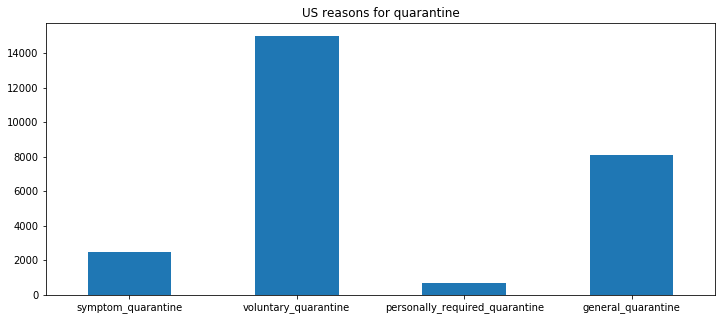

In [1110]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,5))
US_quarantinetype_df = cleaner_data_df[cleaner_data_df.country_code == 'US'][['country_code','symptom_quarantine','voluntary_quarantine','personally_required_quarantine','general_quarantine']]
grouped_US_quarantinetype_df = US_quarantinetype_df.groupby('country_code').sum().reset_index(drop=True)
grouped_US_quarantinetype_df.loc[0].plot.bar()
plt.title("US reasons for quarantine")
plt.xticks(rotation=0)
plt.show()